In [41]:
%pip install --upgrade DBcm

Note: you may need to restart the kernel to use updated packages.


In [42]:
import DBcm

In [43]:
credentials = {
    "host": "localhost",
    "database": "BlackjackDB",
    "user": "richard",
    "password": "richpassword"
}

In [44]:
import random

In [45]:
users = ("Reacu","JosherFella","Rooblan","BarPaul","Coor")

In [ ]:
#Clears data

# for user in users:
#     with DBcm.UseDatabase(credentials) as db:
#         SQL = "DELETE FROM user_statistics WHERE user = %s"
#         db.execute(SQL, (user,))
#         SQL = "DELETE FROM user_game_statistics WHERE user = %s"
#         db.execute(SQL, (user,))
#         print(f"Data for user {user} cleared from user_game_statistics table.")

In [46]:
##Populate database with Data
users = ("Reacu","JosherFella","Rooblan","BarPaul","Coor")
outcomes = ["Win","Loss","Bust"]
outcome_weights = [0.4,0.4,0.1]

for user in users:
    #Insert raw data
    for _ in range(100):
        with DBcm.UseDatabase(credentials) as db:
            SQL = """ 
                insert into user_game_statistics
                (user, outcomes)
                values
                (%s, %s)
            """
            outcome = random.choices(outcomes, weights=outcome_weights)[0]
            
            db.execute(SQL,(user,outcome))

    #update statistical data
    with DBcm.UseDatabase(credentials) as db:
        SQL = """
            select count(*) from user_game_statistics
            where user = %s and outcomes = "Win"
    """
        db.execute(SQL,(user,))
        results = db.fetchone()
        wins = results[0]

        SQL = """
            select count(*) from user_game_statistics 
            where user = %s and outcomes = "Loss"
        """
        db.execute(SQL, (user, ))   # single value, not a tuple.
        results = db.fetchone() 
        losses = results[0]

        SQL = """
            select count(*) from user_game_statistics 
            where user = %s and outcomes = "Bust"
        """
        db.execute(SQL, (user, ))   # single value, not a tuple.
        results = db.fetchone() 
        busts = results[0]

        #Highest win streak

        SQL = """
            select * from user_game_statistics 
            where user = %s
        """
        db.execute(SQL,(user,))
        results = db.fetchall()

        highest_win_streak = 0
        current_streak_count = 0

        for result in results:
            if result[1] == "Win":
                current_streak_count += 1
            if result[1] != "Win":
                if current_streak_count > highest_win_streak: 
                    highest_win_streak = current_streak_count
                current_streak_count = 0            
        #update user stats table

        SQL = """
    	    insert into user_statistics
            (user, win_rate, bust_rate, highest_win_streak)
            values
            (%s , %s, %s, %s)
        """
       

        winRatio = wins / (wins+losses+busts)
        bustRatio = busts / (wins+losses+busts)
        db.execute(SQL,(user,winRatio,bustRatio,highest_win_streak,))

In [47]:
scores = {}

for user in users:
    with DBcm.UseDatabase(credentials) as db:    
        SQL = """
            select win_rate from user_statistics 
            where user = %s
        """
        db.execute(SQL, (user,))   # tuple.
        win_rate = db.fetchone()  

    scores[user] = win_rate[0]

In [48]:
busts = {}

for user in users:
    with DBcm.UseDatabase(credentials) as db:    
        SQL = """
            select bust_rate from user_statistics 
            where user = %s
        """
        db.execute(SQL, (user,))   # tuple.
        bust_rate = db.fetchone()  

    busts[user] = bust_rate[0]

In [49]:
highest_win_streaks = {}

for user in users:
    with DBcm.UseDatabase(credentials) as db:    
        SQL = """
            select highest_win_streak from user_statistics 
            where user = %s
        """
        db.execute(SQL, (user,))   # tuple.
        highest_win_streak = db.fetchone()  

    highest_win_streaks[user] = highest_win_streak[0]

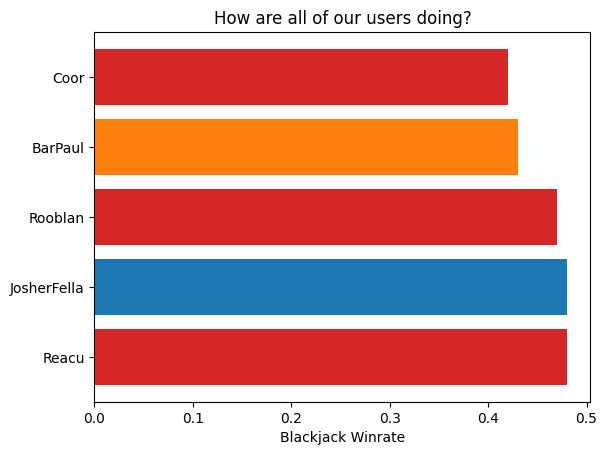

In [52]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

y_labels = list(scores.keys())
x_values = list(scores.values())


bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']

ax.barh(y_labels, x_values, color=bar_colors)


ax.set_xlabel('Blackjack Winrate')
ax.set_title('How are all of our users doing?')

plt.show()

Text(0.5, 1.0, 'The highest win streaks of our users')

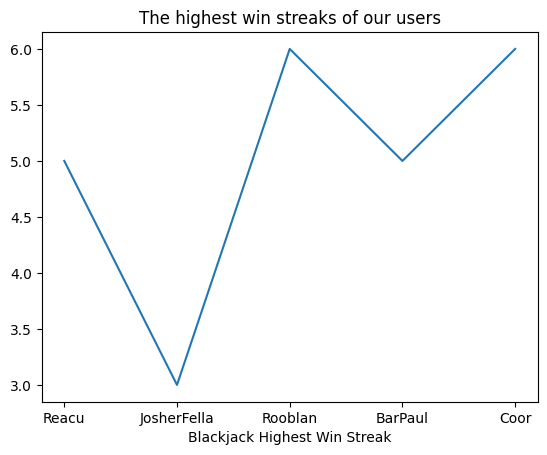

In [53]:
import matplotlib.pyplot as plt

y_labels = list(highest_win_streaks.keys())
x_values = list(highest_win_streaks.values())

fig, axs = plt.subplots()
axs.plot(y_labels, x_values)

axs.set_xlabel('Blackjack Highest Win Streak')
axs.set_title('The highest win streaks of our users')

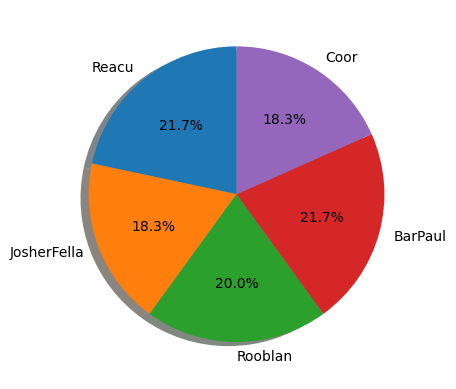

In [54]:
import matplotlib.pyplot as plt

labels = busts.keys()
win_streaks = busts.values()

fig, ax = plt.subplots()

#explode highestr streak later
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
#ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
       #shadow={'ox': -0.04, 'edgecolor': 'none', 'shade': 0.9}, startangle=90)

ax.pie(win_streaks, labels=labels, autopct='%1.1f%%',
       shadow={'ox': -0.04, 'edgecolor': 'none', 'shade': 0.9}, startangle=90)
plt.show()